In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.sparse import csr_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F

# os.chdir("../python/")

## Model class

In [2]:
class ModelBoeck(nn.Module):
    def __init__(self):
        super(ModelBoeck, self).__init__()
        
        # Model parameters
        self.input_size = 120
        self.output_size = 2
        self.num_layers = 3
        self.hidden_size = 25     
        self.bidirectional = True
        self.num_directions = 2 if self.bidirectional else 1
        
        # Recurrent layer 
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size, 
                            num_layers=self.num_layers, 
                            bidirectional=self.bidirectional,
                            batch_first=True)
        
        # Read out layer
        self.fc = nn.Linear(self.num_directions * self.hidden_size, self.output_size)       
        
    def forward(self, x): 
        
#         packed = pack_padded_sequence(x, lengths, batch_first=True)
        
        lstm_out, _ = self.lstm(x) 
        
#         lstm_out, _ = pad_packed_sequence(lstm_out, batch_first=True)
        
        fc_out = self.fc(lstm_out)
        
        y = F.log_softmax(fc_out, dim=2)
        
        return torch.transpose(y, 1, 2)

## Load data

In [3]:
features = pickle.load(open('../data/pickle/ballroom_features_boeck.npy', 'rb'))

labels = pickle.load(open('../data/pickle/ballroom_labels_boeck.npy', 'rb'))

## Model

In [4]:
model = ModelBoeck()
model.load_state_dict(torch.load('../models/model_boeck.pt'))
model.eval()

ModelBoeck(
  (lstm): LSTM(120, 25, num_layers=3, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=50, out_features=2, bias=True)
)

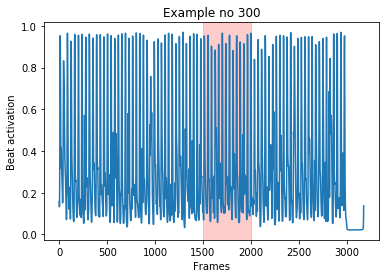

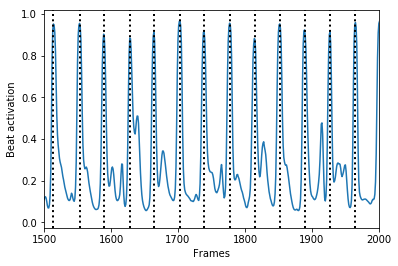

In [5]:
examples = [300]

for example in examples:

    test_input = features[example].view(1, len(features[example]),-1)
    test_label = labels[example]

    with torch.no_grad():
        out = model(test_input)

    activations = np.exp(np.array(out[0,1,:]))

    zoom = (1500, 2000)

    plt.figure()
    plt.plot(activations)
    plt.xlabel('Frames')
    plt.ylabel('Beat activation')
    plt.axvspan(zoom[0], zoom[1], alpha=0.2, color='red')
    plt.title('Example no {}'.format(example))


    plt.figure()   
    plt.plot(activations)
    plt.xlabel('Frames')
    plt.ylabel('Beat activation')
    for beat in np.where(test_label == 1.0)[0]:
        plt.axvline(x=beat, color='k', linestyle=':', linewidth=2)
    plt.xlim(zoom);
    
observations = activations

## State space model 

In [6]:
fps = 100

min_bpm = 56
max_bpm = 215

min_interval = 60. * fps / max_bpm
max_interval = 60. * fps / min_bpm

print('Min interval: {} \nMax interval: {} \nNumber of intervals: {}'
      .format(int(np.round(min_interval)), int(np.round(max_interval)), 
              int(np.round(max_interval) + 1 - np.round(min_interval))))

Min interval: 28 
Max interval: 107 
Number of intervals: 80


In [7]:
intervals = np.arange(np.round(min_interval), np.round(max_interval) + 1)

num_intervals = None

if num_intervals is not None and num_intervals < len(intervals):
        # we must approach the number of intervals iteratively
    num_log_intervals = num_intervals
    intervals = []
    while len(intervals) < num_intervals:
        intervals = np.logspace(np.log2(min_interval),
                                np.log2(max_interval),
                                num_log_intervals, base=2)
        # quantize to integer intervals
        intervals = np.unique(np.round(intervals))
        num_log_intervals += 1
        
intervals = np.ascontiguousarray(intervals, dtype=np.int)

# number of states and intervals
num_states = int(np.sum(intervals))
num_intervals = len(intervals)


# define first and last states
first_states = np.cumsum(np.r_[0, intervals[:-1]])
first_states = first_states.astype(np.int)

last_states = np.cumsum(intervals) - 1

# define the positions and intervals of the states
state_positions = np.empty(num_states)
state_intervals = np.empty(num_states, dtype=np.int)
# Note: having an index counter is faster than ndenumerate
idx = 0
for i in intervals:
    state_positions[idx: idx + i] = np.linspace(0, 1, i, endpoint=False)
    state_intervals[idx: idx + i] = i
    idx += i

## Transition model

In [8]:
def exponential_transition(from_intervals, to_intervals, transition_lambda,
                           threshold=np.spacing(1), norm=True):
    # no transition lambda
    if transition_lambda is None:
        # return a diagonal matrix
        return np.diag(np.diag(np.ones((len(from_intervals),
                                        len(to_intervals)))))
    # compute the transition probabilities
    ratio = (to_intervals.astype(np.float) /
             from_intervals.astype(np.float)[:, np.newaxis])
    prob = np.exp(-transition_lambda * abs(ratio - 1.))
    # set values below threshold to 0
    prob[prob <= threshold] = 0
    # normalize the emission probabilities
    if norm:
        prob /= np.sum(prob, axis=1)[:, np.newaxis]
    return prob


def make_sparse(states, prev_states, probabilities):
    # check for a proper probability distribution, i.e. the emission
    # probabilities of each prev_state must sum to 1
    states = np.asarray(states)
    prev_states = np.asarray(prev_states, dtype=np.int)
    probabilities = np.asarray(probabilities)
    if not np.allclose(np.bincount(prev_states, weights=probabilities), 1):
        raise ValueError('Not a probability distribution.')
    # convert everything into a sparse CSR matrix, make sure it is square.
    # looking through prev_states is enough, because there *must* be a
    # transition *from* every state
    num_states = max(prev_states) + 1
    transitions = csr_matrix((probabilities, (states, prev_states)),
                             shape=(num_states, num_states))
    # convert to correct types
    states = transitions.indices.astype(np.uint32)
    pointers = transitions.indptr.astype(np.uint32)
    probabilities = transitions.data.astype(dtype=np.float)
    # return them
    return states, pointers, probabilities


transition_lambda = 100.0

# same tempo transitions probabilities within the state space is 1
# Note: use all states, but remove all first states because there are
#       no same tempo transitions into them
states = np.arange(num_states, dtype=np.uint32)
states = np.setdiff1d(states, first_states)
prev_states = states - 1
probabilities = np.ones_like(states, dtype=np.float)

# tempo transitions occur at the boundary between beats
# Note: connect the beat state space with itself, the transitions from
#       the last states to the first states follow an exponential tempo
#       transition (with the tempi given as intervals)
to_states = first_states
from_states = last_states
from_int = state_intervals[from_states]
to_int = state_intervals[to_states]
prob = exponential_transition(from_int, to_int, transition_lambda)
# use only the states with transitions to/from != 0
from_prob, to_prob = np.nonzero(prob)
states = np.hstack((states, to_states[to_prob]))
prev_states = np.hstack((prev_states, from_states[from_prob]))
probabilities = np.hstack((probabilities, prob[prob != 0]))
# make the transitions sparse
transitions = make_sparse(states, prev_states, probabilities)
# instantiate a TransitionModel
# super(BeatTransitionModel, self).__init__(*transitions)

states, pointers, probabilities = zip(transitions)

log_probabilities = np.log(probabilities)

## Observation model

In [9]:
observation_lambda = 16

pointers = np.zeros(num_states, dtype=np.uint32)

# unless they are in the beat range of the state space
border = 1. / observation_lambda
    
pointers[state_positions < border] = 1


log_densities = np.empty((len(observations), 2), dtype=np.float)
# Note: it's faster to call np.log 2 times instead of once on the
#       whole 2d array
log_densities[:, 0] = np.log((1. - observations) /
                             (observation_lambda - 1))
log_densities[:, 1] = np.log(observations)

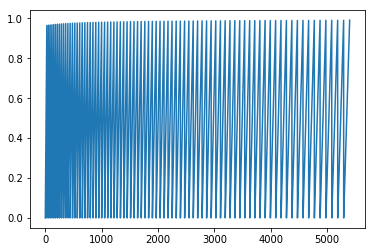

In [70]:
plt.plot(state_positions)

## Hidden Markov model

In [10]:
initial_distribution = np.ones(num_states, dtype=np.float) / num_states

In [12]:
%load_ext Cython

In [28]:
%%cython

cimport numpy as np
import numpy as np

import warnings

cimport cython

from numpy.math cimport INFINITY

ctypedef np.uint32_t uint32_t

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def viterbi(observations, states, pointers, log_probabilities, 
            num_states, log_densities, initial_distribution):
    # transition model stuff
    cdef uint32_t [::1] tm_states = states
    cdef uint32_t [::1] tm_pointers = pointers
    cdef double [::1] tm_probabilities = log_probabilities
    cdef unsigned int tm_num_states = num_states

    # observation model stuff
    cdef unsigned int num_observations = len(observations)
    cdef uint32_t [::1] om_pointers = pointers
    cdef double [:, ::1] om_densities = log_densities

    # current viterbi variables
    cdef double [::1] current_viterbi = np.empty(num_states, dtype=np.float)

    # previous viterbi variables, init with the initial state distribution
    cdef double [::1] previous_viterbi = np.log(initial_distribution)

    # back-tracking pointers
    cdef uint32_t [:, ::1] bt_pointers = np.empty((num_observations,
                                                   num_states),
                                                  dtype=np.uint32)
    # define counters etc.
    cdef unsigned int state, frame, prev_state, pointer
    cdef double density, transition_prob

    # iterate over all observations
    for frame in range(num_observations):
        # search for the best transition
        for state in range(num_states):
            # reset the current viterbi variable
            current_viterbi[state] = -INFINITY
            # get the observation model probability density value
            # the om_pointers array holds pointers to the correct
            # observation probability density value for the actual state
            # (i.e. column in the om_densities array)
            # Note: defining density here gives a 5% speed-up!?
            density = om_densities[frame, om_pointers[state]]
            # iterate over all possible previous states
            # the tm_pointers array holds pointers to the states which are
            # stored in the tm_states array
            for pointer in range(tm_pointers[state],
                                 tm_pointers[state + 1]):
                # get the previous state
                prev_state = tm_states[pointer]
                # weight the previous state with the transition probability
                # and the current observation probability density
                transition_prob = previous_viterbi[prev_state] + \
                                  tm_probabilities[pointer] + density
                # if this transition probability is greater than the
                # current one, overwrite it and save the previous state
                # in the back tracking pointers
                if transition_prob > current_viterbi[state]:
                    # update the transition probability
                    current_viterbi[state] = transition_prob
                    # update the back tracking pointers
                    bt_pointers[frame, state] = prev_state

        # overwrite the old states with the current ones
        previous_viterbi[:] = current_viterbi

    # fetch the final best state
    state = np.asarray(current_viterbi).argmax()
    # set the path's probability to that of the best state
    log_probability = current_viterbi[state]

    # raise warning if the sequence has -inf probability
    if np.isinf(log_probability):
        warnings.warn('-inf log probability during Viterbi decoding '
                      'cannot find a valid path', RuntimeWarning)
        # return empty path sequence
        return np.empty(0, dtype=np.uint32), log_probability

    # back tracked path, a.k.a. path sequence
    path = np.empty(num_observations, dtype=np.uint32)
    # track the path backwards, start with the last frame and do not
    # include the pointer for frame 0, since it includes the transitions
    # to the prior distribution states
    for frame in range(num_observations -1, -1, -1):
        # save the state in the path
        path[frame] = state
        # fetch the next previous one
        state = bt_pointers[frame, state]

    # return the tracked path and its probability
    return path, log_probability, bt_pointers

## Process

In [62]:


threshold = 0
correct = True

beats = np.empty(0, dtype=np.int)
first = 0
# use only the activations > threshold
if threshold:
    idx = np.nonzero(activations >= self.threshold)[0]
    if idx.any():
        first = max(first, np.min(idx))
        last = min(len(activations), np.max(idx) + 1)
    else:
        last = first
    activations = activations[first:last]
# return the beats if no activations given / remain after thresholding
# if not activations.any():
#     return beats

path, _, bt_pointers = viterbi(activations, states[0], pointers, log_probabilities[0], 
                  num_states, log_densities, initial_distribution)

if correct:
    # for each detection determine the "beat range", i.e. states where
    # the pointers of the observation model are 1
    beat_range = pointers[path]
    print('test')
    # get all change points between True and False
    idx = np.nonzero(np.diff(beat_range))[0] + 1
    # if the first frame is in the beat range, add a change at frame 0
    if beat_range[0]:
        idx = np.r_[0, idx]
    # if the last frame is in the beat range, append the length of the
    # array
    if beat_range[-1]:
        idx = np.r_[idx, beat_range.size]
    # iterate over all regions
    if idx.any():
        for left, right in idx.reshape((-1, 2)):
            # pick the frame with the highest activations value
            peak = np.argmax(activations[left:right]) + left
            beats = np.hstack((beats, peak))
else:
    # just take the frames with the smallest beat state values
    from scipy.signal import argrelmin
    beats = argrelmin(state_positions[path], mode='wrap')[0]
    # recheck if they are within the "beat range", i.e. the pointers
    # of the observation model for that state must be 1
    # Note: interpolation and alignment of the beats to be at state 0
    #       does not improve results over this simple method
    beats = beats[pointers[path[beats]] == 1]
# convert the detected beats to seconds and return them


final = (beats + first) / float(fps)

test


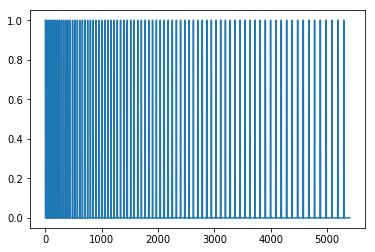

In [66]:
plt.plot(pointers)

(25, 30)

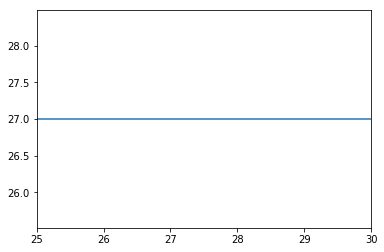

In [57]:
plt.plot(bt_pointers[:,27]);
plt.xlim([25, 30])

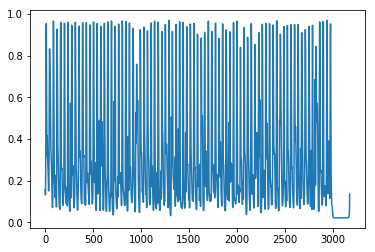

In [16]:
plt.plot(activations)

## Appendix

In [2]:
f_r = 100
Phi = 640

In [6]:
W = 23
w = np.arange(6, W+1)

BPM = w * 60 * f_r / Phi

In [7]:
w

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23])

In [8]:
BPM

array([ 56.25 ,  65.625,  75.   ,  84.375,  93.75 , 103.125, 112.5  ,
       121.875, 131.25 , 140.625, 150.   , 159.375, 168.75 , 178.125,
       187.5  , 196.875, 206.25 , 215.625])

In [9]:
p_w = 0.002